# Coursera IBM Data Science Professional Certificate
## Capstone Project: Analysis of Venue Data in Manhattan Neighborhoods
Author: Adam Horin  
Date: September 19, 2019

## Table of contents
[1. Introduction: Background and Problem](#introduction)  
[2. Data](#data)  
[3. Methods](#methods)   
[4. Results](#results)  
[5. Discussion and Conclusion](#conclusion)  
[6. References](#references)

## 1. Introduction: Background and Problem <a name="introduction"></a>
Sunac Natural Market is a health food business that offers organic, health-conscious foods to their customers [1]. With a rise in health and wellness awareness, it is not surprising health-related businesses are intereted in expanding. This project will suggest candidate neighborhoods for Sunac Natrual Market to expand to a new location in a Manhattan neighborhood. One factor that could contribute to health food markets' success in their current locations could be the similarities in surrounding venues. If they are looking to expand, they should likely look into neighborhoods that share these similarities. This project will use a k-means clustering method to cluster neighborhoods based on similarities in venues. Based on the outcomes of this analysis a suggestion can be made for candidate neighborhoods to look into for expansion locations.

## 2. Data <a name="data"></a>  
The following data was used for this project:  
- Data from the NYU repository of geospatial data for the neighborhoods and boroughs of New York City, NY.  
- Data from the Foursquare API on venues in the neighborhoods and boroughs of New York City, NY.  


## 3. Methods <a name="methods"></a>
#### Download all dependencies that are necessary to conduct this analysis.
These libraries all contain the necessary functions to conduct the analyses.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


Open and explore the data from the NYU dataset.

In [2]:
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features'] #convert the features of the data set into a dataframe

In [7]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Make a dataframe extracting the borough, neighborhood, and coordinates from the data.

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [9]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [10]:
#extracts the coordinates from the data
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [11]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Filter the neighborhoods to only Manhattan.

In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


In [14]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Use the Foursquare API to obtain venue data for the Manhattan neighborhoods.

In [15]:
CLIENT_ID = 'E25M1JQ0A4BN1BYUQALEUTPG5KP1J3NYQ0QSMME5ZUNEWWVX' # your Foursquare ID
CLIENT_SECRET = 'RDUA3E3PSDEIVS2OVIJUMIM5QYIXOKLPPZ3GT0435PWWSTXZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: E25M1JQ0A4BN1BYUQALEUTPG5KP1J3NYQ0QSMME5ZUNEWWVX
CLIENT_SECRET:RDUA3E3PSDEIVS2OVIJUMIM5QYIXOKLPPZ3GT0435PWWSTXZ


Create a function to extract the necessary data from the Foursquare API

In [16]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# type your answer here

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'])


Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Table 1. Health Food Stores in Manhattan
The following table lists the current health food stores and their neighborhoods.

In [18]:
print(manhattan_venues.shape)
manhattan_venues.head(100)
manhattan_venues_health = manhattan_venues[manhattan_venues['Venue Category'] == 'Health Food Store']
manhattan_venues_health = manhattan_venues_health[['Neighborhood', 'Venue', 'Venue Category']]
manhattan_venues_health.sort_values(by = 'Venue')

(3330, 7)


,Neighborhood,Venue,Venue Category
666,Lenox Hill,A Matter of Health,Health Food Store
1011,Clinton,Sunac Natural Food,Health Food Store
3297,Hudson Yards,Sunac Natural Food,Health Food Store
2997,Turtle Bay,The Health Nuts,Health Food Store
2089,Manhattan Valley,The Nutbox,Health Food Store


In [19]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 339 uniques categories.


The venues must be one hot encoded since they are categorical variables with no order. This will allow the frequency of each venue to be calculated for each neighborhood.

In [20]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restau

In [21]:
manhattan_onehot.shape

(3330, 340)

This provides the mean frequency of each type of venue for each neighborhood.

In [22]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restau

In [23]:
manhattan_grouped.shape

(40, 340)

In [24]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.09
1    Coffee Shop  0.07
2          Hotel  0.05
3            Gym  0.04
4  Memorial Site  0.04


----Carnegie Hill----
            venue  freq
0     Coffee Shop  0.06
1     Pizza Place  0.06
2            Café  0.04
3  Cosmetics Shop  0.04
4     Yoga Studio  0.03


----Central Harlem----
                  venue  freq
0    African Restaurant  0.06
1  Gym / Fitness Center  0.04
2            Public Art  0.04
3                   Bar  0.04
4    Chinese Restaurant  0.04


----Chelsea----
                venue  freq
0         Coffee Shop  0.06
1  Italian Restaurant  0.05
2      Ice Cream Shop  0.05
3              Bakery  0.05
4           Nightclub  0.04


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.09
1           Cocktail Bar  0.05
2                 Bakery  0.04
3    American Restaurant  0.04
4  Vietnamese Restaurant  0.04


----Civic Center----
                  venue  freq
0  Gym / Fitness C

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Memorial Site,Gym,Italian Restaurant,Wine Shop,Clothing Store,Plaza,Playground
1,Carnegie Hill,Coffee Shop,Pizza Place,Cosmetics Shop,Café,Japanese Restaurant,Grocery Store,French Restaurant,Yoga Studio,Bookstore,Bar
2,Central Harlem,African Restaurant,Chinese Restaurant,French Restaurant,Gym / Fitness Center,American Restaurant,Bar,Public Art,Seafood Restaurant,Fried Chicken Joint,Southern / Soul Food Restaurant
3,Chelsea,Coffee Shop,Italian Restaurant,Bakery,Ice Cream Shop,Nightclub,Hotel,Theater,American Restaurant,Seafood Restaurant,Tapas Restaurant
4,Chinatown,Chinese Restaurant,Cocktail Bar,Vietnamese Restaurant,Bakery,American Restaurant,Spa,Salon / Barbershop,Bubble Tea Shop,Korean Restaurant,Asian Restaurant
5,Civic Center,Gym / Fitness Center,Italian Restaurant,Coffee Shop,French Restaurant,Hotel,Sandwich Place,Sporting Goods Shop,American Restaurant,Cocktail Bar,Park
6,Clinton,Theater,Gym / Fitness Center,American Restaurant,Spa,Italian Restaurant,Hotel,Wine Shop,French Restaurant,Coffee Shop,Cocktail Bar
7,East Harlem,Mexican Restaurant,Bakery,Deli / Bodega,Latin American Restaurant,Thai Restaurant,Sandwich Place,Donut Shop,Coffee Shop,Cocktail Bar,Beer Bar
8,East Village,Bar,Ice Cream Shop,Wine Bar,Mexican Restaurant,Pizza Place,Chinese Restaurant,Cocktail Bar,Ramen Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop
9,Financial District,Coffee Shop,Pizza Place,Wine Shop,Hotel,Gym,Event Space,American Restaurant,Gym / Fitness Center,Cocktail Bar,Steakhouse


## 4. Results <a name="results"></a>

In [27]:
# set number of clusters
kclusters = 6

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 0, 4, 0, 0, 4, 1, 0], dtype=int32)

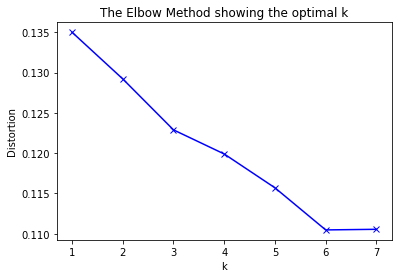

In [33]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(manhattan_grouped_clustering)
    kmeanModel.fit(manhattan_grouped_clustering)
    distortions.append(sum(np.min(cdist(manhattan_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / manhattan_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [37]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged[['Neighborhood', 'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']].sort_values('Cluster Labels') # check the last columns!

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
39,Hudson Yards,0,American Restaurant,Italian Restaurant,Gym / Fitness Center
21,Tribeca,0,Italian Restaurant,American Restaurant,Park
24,West Village,0,Italian Restaurant,Cosmetics Shop,New American Restaurant
38,Flatiron,0,Gym / Fitness Center,Yoga Studio,American Restaurant
18,Greenwich Village,0,Italian Restaurant,Clothing Store,Sushi Restaurant
17,Chelsea,0,Coffee Shop,Italian Restaurant,Bakery
16,Murray Hill,0,Coffee Shop,Hotel,Japanese Restaurant
15,Midtown,0,Hotel,Coffee Shop,Cocktail Bar
14,Clinton,0,Theater,Gym / Fitness Center,American Restaurant
13,Lincoln Square,0,Theater,Gym / Fitness Center,Café


In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
manhattan_venues_health.sort_values(by = 'Venue')

,Neighborhood,Venue,Venue Category
666,Lenox Hill,A Matter of Health,Health Food Store
1011,Clinton,Sunac Natural Food,Health Food Store
3297,Hudson Yards,Sunac Natural Food,Health Food Store
2997,Turtle Bay,The Health Nuts,Health Food Store
2089,Manhattan Valley,The Nutbox,Health Food Store


In [41]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Central Harlem,African Restaurant,Chinese Restaurant,French Restaurant,Gym / Fitness Center,American Restaurant,Bar,Public Art,Seafood Restaurant,Fried Chicken Joint,Southern / Soul Food Restaurant
8,Upper East Side,Italian Restaurant,Exhibit,Art Gallery,Bakery,Coffee Shop,Juice Bar,French Restaurant,Gym / Fitness Center,Hotel,Spa
13,Lincoln Square,Theater,Gym / Fitness Center,Café,Plaza,Concert Hall,Italian Restaurant,Park,Performing Arts Venue,Indie Movie Theater,French Restaurant
14,Clinton,Theater,Gym / Fitness Center,American Restaurant,Spa,Italian Restaurant,Hotel,Wine Shop,French Restaurant,Coffee Shop,Cocktail Bar
15,Midtown,Hotel,Coffee Shop,Cocktail Bar,Clothing Store,Theater,Steakhouse,Bakery,Bookstore,Sporting Goods Shop,Japanese Restaurant
16,Murray Hill,Coffee Shop,Hotel,Japanese Restaurant,Sandwich Place,Italian Restaurant,Gym / Fitness Center,American Restaurant,Gym,French Restaurant,Pub
17,Chelsea,Coffee Shop,Italian Restaurant,Bakery,Ice Cream Shop,Nightclub,Hotel,Theater,American Restaurant,Seafood Restaurant,Tapas Restaurant
18,Greenwich Village,Italian Restaurant,Clothing Store,Sushi Restaurant,Café,Seafood Restaurant,Indian Restaurant,Cosmetics Shop,Chinese Restaurant,French Restaurant,Vietnamese Restaurant
21,Tribeca,Italian Restaurant,American Restaurant,Park,Café,Spa,Boutique,Wine Shop,Wine Bar,Gym,Greek Restaurant
22,Little Italy,Bakery,Café,Ice Cream Shop,Sandwich Place,Salon / Barbershop,Clothing Store,Mediterranean Restaurant,Hotel,Yoga Studio,Massage Studio


In [42]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Manhattanville,Coffee Shop,Italian Restaurant,Sushi Restaurant,Park,Mexican Restaurant,Seafood Restaurant,Café,Lounge,Bike Trail,Supermarket
9,Yorkville,Italian Restaurant,Gym,Bar,Coffee Shop,Pizza Place,Deli / Bodega,Sushi Restaurant,Mexican Restaurant,Wine Shop,Japanese Restaurant
10,Lenox Hill,Italian Restaurant,Coffee Shop,Pizza Place,Sushi Restaurant,Burger Joint,Café,Gym,Gym / Fitness Center,Sporting Goods Shop,Cosmetics Shop
12,Upper West Side,Italian Restaurant,Wine Bar,Coffee Shop,Indian Restaurant,Bakery,Bar,Vegetarian / Vegan Restaurant,Thai Restaurant,Pub,Bookstore
19,East Village,Bar,Ice Cream Shop,Wine Bar,Mexican Restaurant,Pizza Place,Chinese Restaurant,Cocktail Bar,Ramen Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop
25,Manhattan Valley,Coffee Shop,Pizza Place,Indian Restaurant,Mexican Restaurant,Thai Restaurant,Spa,French Restaurant,Deli / Bodega,Yoga Studio,Bar
27,Gramercy,Bar,Italian Restaurant,American Restaurant,Pizza Place,Bagel Shop,Cocktail Bar,Mexican Restaurant,Ice Cream Shop,Hotel,Grocery Store
30,Carnegie Hill,Coffee Shop,Pizza Place,Cosmetics Shop,Café,Japanese Restaurant,Grocery Store,French Restaurant,Yoga Studio,Bookstore,Bar
35,Turtle Bay,Italian Restaurant,Sushi Restaurant,Steakhouse,Wine Bar,Coffee Shop,Indian Restaurant,Café,French Restaurant,Ramen Restaurant,Japanese Restaurant
36,Tudor City,Mexican Restaurant,Park,Café,Greek Restaurant,Sushi Restaurant,Deli / Bodega,Pizza Place,Diner,Spanish Restaurant,Gym


In [43]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Park,Bar,Playground,Boat or Ferry,Fountain,Basketball Court,Baseball Field,Harbor / Marina,Cocktail Bar,Coffee Shop


In [44]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,Korean Restaurant,Hotel Bar,Hotel,Japanese Restaurant,Cosmetics Shop,American Restaurant,Coffee Shop,Dessert Shop,Gym / Fitness Center,Yoga Studio


In [45]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sandwich Place,Coffee Shop,Yoga Studio,Discount Store,Steakhouse,Miscellaneous Shop,Supplement Shop,Seafood Restaurant,Tennis Stadium,Gym
1,Chinatown,Chinese Restaurant,Cocktail Bar,Vietnamese Restaurant,Bakery,American Restaurant,Spa,Salon / Barbershop,Bubble Tea Shop,Korean Restaurant,Asian Restaurant
2,Washington Heights,Café,Bakery,Mobile Phone Shop,Spanish Restaurant,Grocery Store,Chinese Restaurant,Supermarket,Deli / Bodega,Tapas Restaurant,Coffee Shop
3,Inwood,Café,Mexican Restaurant,Pizza Place,Lounge,Bakery,Park,Chinese Restaurant,Spanish Restaurant,Deli / Bodega,Frozen Yogurt Shop
4,Hamilton Heights,Mexican Restaurant,Café,Pizza Place,Deli / Bodega,Coffee Shop,Yoga Studio,Liquor Store,Indian Restaurant,Park,Sushi Restaurant
7,East Harlem,Mexican Restaurant,Bakery,Deli / Bodega,Latin American Restaurant,Thai Restaurant,Sandwich Place,Donut Shop,Coffee Shop,Cocktail Bar,Beer Bar
20,Lower East Side,Coffee Shop,Pizza Place,Café,Chinese Restaurant,Ramen Restaurant,Park,Cocktail Bar,Japanese Restaurant,Bakery,Art Gallery
26,Morningside Heights,American Restaurant,Park,Coffee Shop,Bookstore,Food Truck,Deli / Bodega,Tennis Court,Burger Joint,Sandwich Place,Farmers Market


In [46]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Roosevelt Island,Park,Deli / Bodega,Coffee Shop,Sandwich Place,Hotpot Restaurant,Liquor Store,Metro Station,Supermarket,Bus Line,Noodle House


In [47]:
df_bar = manhattan_merged[['Neighborhood', 'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']]
df_bar.head()

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Marble Hill,4,Sandwich Place,Coffee Shop,Yoga Studio
1,Chinatown,4,Chinese Restaurant,Cocktail Bar,Vietnamese Restaurant
2,Washington Heights,4,Café,Bakery,Mobile Phone Shop
3,Inwood,4,Café,Mexican Restaurant,Pizza Place
4,Hamilton Heights,4,Mexican Restaurant,Café,Pizza Place


In [48]:
df_bar_transform = pd.melt(df_bar,id_vars=['Neighborhood', 'Cluster Labels'],var_name='Common Venues', value_name='Venue')
df_bar_transform = df_bar_transform[['Cluster Labels', 'Venue']]
df_bar_transform.head()

,Cluster Labels,Venue
0,4,Sandwich Place
1,4,Chinese Restaurant
2,4,Café
3,4,Café
4,4,Mexican Restaurant


In [49]:
df_bar_transform['Venue'].unique()

array(['Sandwich Place', 'Chinese Restaurant', 'Café',
       'Mexican Restaurant', 'Coffee Shop', 'African Restaurant',
       'Italian Restaurant', 'Park', 'Theater', 'Hotel', 'Bar', 'Bakery',
       'Clothing Store', 'American Restaurant', 'Gym / Fitness Center',
       'Korean Restaurant', 'Cocktail Bar', 'Exhibit', 'Gym',
       'Deli / Bodega', 'Wine Bar', 'Ice Cream Shop', 'Pizza Place',
       'Boutique', 'Cosmetics Shop', 'Art Gallery', 'Hotel Bar',
       'Sushi Restaurant', 'Yoga Studio', 'Vietnamese Restaurant',
       'Mobile Phone Shop', 'French Restaurant', 'Japanese Restaurant',
       'New American Restaurant', 'Indian Restaurant', 'Wine Shop',
       'Steakhouse', 'Playground'], dtype=object)

## 5. Discussion and Conclusion  <a name="conclusion"></a>
Based on the clustering it could be recommended that Sunac Health Market opens an expansion location in another neighborhood in cluster 0. The current Sunac Health Market Locations are in the Clinton and Hudson Yards neighborhoods, which are both in cluster 0. Many of the neighborhoods in this cluster have a gym/fitness center in their top five most common venues, which would make sense as to why a health food store would likely be successful in these neighborhoods. The remaining neighborhoods in this cluster do not contain health food stores, so over saturating that market would not be as much of a concern.

There are limitations to this data analysis. First, the outcomes are only based on types of venues in each neighborhood of Manhattan. There are many other factors that should be considered when picking a business location, such as market retail prices and population demographics of the neighborhood. While similarities in venues can provide some evidence of potential success, other factors should be examined in order to narrow the search to fewer candidate locations.

## 6. References <a name="references"></a>

[1] https://www.sunacnaturalmarket.com/

[2] https://cocl.us/new_york_dataset

[3] https://developer.foursquare.com/